In [1]:
# Initial imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from matplotlib import pyplot


In [2]:
# import data functions
# imports for creating dataframe
from utils_laramie import get_df, get_all_raw_data

# imports for getting weekly range
from utils_laramie import calc_weekly_range

#imports for grouping data into weekly windows
from utils_laramie import grp_y_wk_d, drop_off_weeks

#shape data
from utils_laramie import get_X_y

In [3]:
# import lstm functions
from lstm_4d import window_data, data_splited_scaled, lstm_model, model_fit, lstm_evaluation, lstm_prediction, predicted_plotting



In [4]:
# get the cleaned data 
df = (get_df(get_all_raw_data()))
df = calc_weekly_range(df)
df = grp_y_wk_d(df)
df = drop_off_weeks(df)
df.tail(10)

,SPY_open,SPY_high,SPY_low,SPY_close,SPY_volume,SPY_trade_count,SPY_vwap,TR,VIX_open,VIX_high,VIX_low,VIX_close,weekly_range
1045,431.58,432.3018,419.36,419.43,131262026.0,1390460.0,424.067609,12.9418,35.88,36.55,32.59,36.45,0.0000
1046,419.87,427.2100,415.12,416.25,158890009.0,1864071.0,419.755053,12.0900,36.19,37.52,32.78,35.13,0.0000
1047,425.16,429.5100,422.83,427.33,110176608.0,1079760.0,426.138376,13.2600,33.74,34.12,31.39,32.45,0.0000
1048,422.42,426.4300,420.44,425.48,91933914.0,891241.0,423.871044,6.8900,33.03,34.03,30.23,30.23,0.0000
1049,428.20,428.7700,419.53,420.07,90803923.0,809145.0,424.040193,9.2400,30.43,31.04,28.84,30.75,17.1818
1050,420.98,424.5500,415.79,417.00,91251505.0,858504.0,419.220077,8.7600,31.03,33.18,30.06,31.77,0.0000
1051,419.66,426.8400,418.42,426.17,104219651.0,920659.0,422.752423,9.8400,33.13,33.83,29.57,29.83,0.0000
1052,429.94,435.6800,424.80,435.55,138130298.0,1344164.0,431.339744,10.8800,29.02,29.80,26.29,26.67,0.0000
1053,433.70,441.0700,433.19,441.07,100157174.0,784018.0,437.706981,7.8800,26.51,27.47,25.25,25.67,0.0000
1054,437.81,444.8600,437.22,444.31,102327793.0,790235.0,441.458916,7.6400,26.36,26.82,23.85,23.87,29.0700


## 3D LSTM Functions
---

In [5]:
# # Set the random seed for reproducibility
# # Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
# from numpy.random import seed

# seed(1)
# from tensorflow import random

# random.set_seed(2)

In [6]:
def window_data(df, window, feature_col_1, feature_col_2, target_col):
    '''
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of X(t )- window to predict y(t).
    It returns two numpy arrays of X and y.
    '''
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_1:feature_col_2]
        target = df.iloc[(i + window), target_col]
        y.append(target)
        X.append(features)
    return np.array(X), np.array(y).reshape(-1, 1)


In [7]:
X,y = window_data(df,5,0,7,7)
print(X[0:5])
print(y[-5:])


[[[2.09200000e+02 2.09729500e+02 2.07200000e+02 2.08270000e+02
   1.02027111e+08 3.74705000e+05 2.08276128e+02]
  [2.06480000e+02 2.08289000e+02 2.05780000e+02 2.06990000e+02
   1.03372367e+08 3.87782000e+05 2.06966276e+02]
  [2.06200000e+02 2.08680000e+02 2.04180000e+02 2.05330000e+02
   1.62401537e+08 5.86210000e+05 2.06034646e+02]
  [2.05440000e+02 2.07430000e+02 2.05140000e+02 2.05860000e+02
   1.16128858e+08 4.04992000e+05 2.06102975e+02]
  [2.03380000e+02 2.04140000e+02 2.01510000e+02 2.01880000e+02
   2.11173305e+08 6.69924000e+05 2.03150102e+02]]

 [[2.06480000e+02 2.08289000e+02 2.05780000e+02 2.06990000e+02
   1.03372367e+08 3.87782000e+05 2.06966276e+02]
  [2.06200000e+02 2.08680000e+02 2.04180000e+02 2.05330000e+02
   1.62401537e+08 5.86210000e+05 2.06034646e+02]
  [2.05440000e+02 2.07430000e+02 2.05140000e+02 2.05860000e+02
   1.16128858e+08 4.04992000e+05 2.06102975e+02]
  [2.03380000e+02 2.04140000e+02 2.01510000e+02 2.01880000e+02
   2.11173305e+08 6.69924000e+05 2.0315

In [8]:
def data_splited_scaled(df, window, feature_col_1,feature_col_2, target_col):
    '''
    This function splits X and y into training and testing sets, scales the data with MinMaxScaler and reshapes features data for the 3 dimentional LSTM model .
    '''  
    X, y = window_data(df, window, feature_col_1,feature_col_2, target_col)
    # Use 70% of the data for training and the remainder for testing
    split = int(0.7 * len(X))
    X_train = X[: split]
    X_test = X[split:]
    y_train = y[: split]
    y_test = y[split:]

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the MinMaxScaler object with the training feature data X_train
    scaler.fit(X_train.ravel().reshape(-1,1))

    # Scale the features training and testing sets
    X_train_scaled= scaler.transform(X_train.ravel().reshape(-1,1))
    X_test_scaled = scaler.transform(X_test.ravel().reshape(-1,1))

    # Fit the MinMaxScaler object with the training target data y_train
    scaler.fit(y_train)

    # Scale the target training and testing sets
    y_train_scaled = scaler.transform(y_train)
    y_test_scaled = scaler.transform(y_test)

    # Reshape the features for the model
    feature_num = feature_col_2 - feature_col_1
    X_train_scaled = X_train_scaled.reshape((X_train.shape[0], X_train.shape[1], feature_num))
    X_test_scaled = X_test_scaled.reshape((X_test.shape[0], X_test.shape[1], feature_num))

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler

In [9]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler = data_splited_scaled(df,5,0,7,7)
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train_scaled.shape)
print(y_test_scaled.shape)
print(X_train_scaled[0:5])

(735, 5, 7)
(315, 5, 7)
(735, 1)
(315, 1)
[[[7.12770043e-08 7.26196288e-08 6.62057126e-08 6.89188537e-08
   2.58704159e-01 9.49659991e-04 6.89343921e-08]
  [6.43800476e-08 6.89670310e-08 6.26050956e-08 6.56732270e-08
   2.62115252e-01 9.82818631e-04 6.56130714e-08]
  [6.36700668e-08 6.99584685e-08 5.85480622e-08 6.14640549e-08
   4.11792321e-01 1.48596176e-03 6.32507876e-08]
  [6.17429760e-08 6.67889112e-08 6.09822822e-08 6.28079472e-08
   2.94461195e-01 1.02645710e-03 6.34240458e-08]
  [5.65195456e-08 5.84466364e-08 5.17778879e-08 5.27160768e-08
   5.35460251e-01 1.69823082e-03 5.59366057e-08]]

 [[6.43800476e-08 6.89670310e-08 6.26050956e-08 6.56732270e-08
   2.62115252e-01 9.82818631e-04 6.56130714e-08]
  [6.36700668e-08 6.99584685e-08 5.85480622e-08 6.14640549e-08
   4.11792321e-01 1.48596176e-03 6.32507876e-08]
  [6.17429760e-08 6.67889112e-08 6.09822822e-08 6.28079472e-08
   2.94461195e-01 1.02645710e-03 6.34240458e-08]
  [5.65195456e-08 5.84466364e-08 5.17778879e-08 5.27160768e-

In [10]:
# def lstm_model(df, window, feature_col_1, feature_col_2, target_col, number_units):
#     '''
#     This function builds and trains a 3-layer LSTM model to fit the 3 dimentional data.
#     '''
#     X_train_scaled, _, y_train_scaled, _ ,_= data_splited_scaled(df, window,feature_col_1, feature_col_2, target_col)

#     # Define the LSTM RNN model.
#     lstm_model = Sequential()

#     dropout_fraction = 0.2
#     # calculate
#     X_train_scaled, _, _, _ ,_= data_splited_scaled(df, window,feature_col_1, feature_col_2, target_col)
#     # Layer 1
#     feature_num = feature_col_2 - feature_col_1
#     lstm_model.add(LSTM(
#     units=number_units,
#     return_sequences=True,
#     input_shape=(X_train_scaled.shape[1], feature_num))
#     )
#     lstm_model.add(Dropout(dropout_fraction))
#     # Layer 2
#     lstm_model.add(LSTM(units=number_units, return_sequences=True))
#     lstm_model.add(Dropout(dropout_fraction))
#     # Layer 3
#     lstm_model.add(LSTM(units=number_units))
#     lstm_model.add(Dropout(dropout_fraction))
#     # Output layer
#     lstm_model.add(Dense(1))

#     # Compile the lstm_model
#     lstm_model.compile(optimizer="adam", loss="mean_squared_error")

#     # Train the lstm_model
#     lstm_model.fit(X_train_scaled, y_train_scaled, epochs=10, shuffle=False, batch_size=1, verbose=1)
#     return lstm_model
    

In [141]:
lstm_model(df,5,0,7,7,64)

Epoch 1/10
735/735 [==============================] - 8s 6ms/step - loss: 0.0084
Epoch 2/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0091
Epoch 3/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0093
Epoch 4/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0089
Epoch 5/10
735/735 [==============================] - 4s 6ms/step - loss: 0.0088
Epoch 6/10
735/735 [==============================] - 4s 6ms/step - loss: 0.0082
Epoch 7/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0081
Epoch 8/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0078
Epoch 9/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0075
Epoch 10/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0073


In [142]:
def lstm_evaluation(df, window,feature_col_1, feature_col_2, target_col, number_units):
    '''
    This function evaluates the 3d LSTM model
    '''
    _, X_test_scaled, _, y_test_scaled,_ =data_splited_scaled(df, window, feature_col_1, feature_col_2, target_col)
    model = lstm_model(df, window, feature_col_1, feature_col_2, target_col, number_units)
    score = model.evaluate(X_test_scaled, y_test_scaled,verbose=0)
    return score

In [143]:
lstm_evaluation(df,5,0,7,7,64)

Epoch 1/10
735/735 [==============================] - 8s 5ms/step - loss: 0.0087
Epoch 2/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0093
Epoch 3/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0091
Epoch 4/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0087
Epoch 5/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0087
Epoch 6/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0082
Epoch 7/10
735/735 [==============================] - 4s 6ms/step - loss: 0.0081
Epoch 8/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0078
Epoch 9/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0077
Epoch 10/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0074


0.009783724322915077

In [144]:
def lstm_prediction(df, window, feature_col_1, feature_col_2, target_col, number_units):
    '''
    This function predicts y values and recover the original prices, and then creates a dataframe of Acural and Predicted values of y
    '''
    _, X_test_scaled, _, y_test_scaled,scaler =data_splited_scaled(df, window, feature_col_1, feature_col_2, target_col)
    model= lstm_model(df, window, feature_col_1, feature_col_2, target_col, number_units)
    y_predicted = model.predict(X_test_scaled)

    # Recover the original prices instead of the scaled version
    predicted_prices = scaler.inverse_transform(y_predicted)
    actual_prices = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

    prediction_df = pd.DataFrame({
        "actual":actual_prices.ravel(),
        "predicted":predicted_prices.ravel(),
    })
    
    return prediction_df

In [145]:
prediction_df = lstm_prediction(df,5,0,7,7,64)
prediction_df

Epoch 1/10
735/735 [==============================] - 9s 5ms/step - loss: 0.0090
Epoch 2/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0091
Epoch 3/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0092
Epoch 4/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0091
Epoch 5/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0086
Epoch 6/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0084
Epoch 7/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0080
Epoch 8/10
735/735 [==============================] - 4s 6ms/step - loss: 0.0076
Epoch 9/10
735/735 [==============================] - 4s 5ms/step - loss: 0.0076
Epoch 10/10
735/735 [==============================] - 4s 6ms/step - loss: 0.0074


,actual,predicted
0,10.4700,6.284304
1,4.2550,6.349226
2,5.9000,6.152833
3,3.9814,5.888935
4,2.4100,5.681957
...,...,...
310,8.7600,6.014125
311,9.8400,5.844094
312,10.8800,5.838216
313,7.8800,6.210278


## 4D LSTM Functions

In [5]:
clean_df = pd.read_csv('clean_data/basic_spy_vix.csv')
clean_df = clean_df.drop(columns='Unnamed: 0')
clean_df.tail()

,pct_change,day_range,pct_changeVIX,mean_volume,VIX_close,tr_weekly,tr_5,tr_project,day_range_VIX,weekly_range
1050,-0.009454,8.76,0.001758,106.291299,31.77,18.757144,10.048,3.360554,3.12,0.00
1051,0.015513,9.84,-0.007864,113.201143,29.83,18.757144,9.598,3.344808,4.26,0.00
1052,0.013048,10.88,-0.005466,102.762980,26.67,18.757144,9.122,3.327879,3.51,0.00
1053,0.016993,7.88,-0.001937,127.748564,25.67,18.757144,9.320,3.334956,2.22,0.00
1054,0.014847,7.64,-0.005687,129.490333,23.87,18.757144,9.000,3.323493,2.97,29.07


In [6]:
df=clean_df
window =3
chunk_rows=5
number_units=1
optimizer='adam'
loss="mean_squared_error"
metrics= ['mse', 'mae']
epochs = 100


In [7]:
# def window_data(df, window, chunk_rows):
#     X_list = df.iloc[:,:-1].values.tolist()
#     X_chunks=[X_list[i:i + chunk_rows] for i in range(0, len(X_list), chunk_rows)]
#     X = [X_chunks[i:i+window] for i in range (len(X_chunks)-window)]
#     y_list=df.iloc[:,-1].values.tolist()
#     y_chunks = [y_list[i + chunk_rows-1] for i in range(0, len(y_list), chunk_rows)]
#     y = [y_chunks[i+window] for i in range(len(y_chunks)-window)]
#     return np.array(X), np.array(y)

In [8]:
X, y = window_data(df, window, chunk_rows)
print(X.shape)
print(y.shape)
print(X[0:5])
print(y[-5:])

(208, 3, 5, 9)
(208,)
[[[[-4.44550669e-03  2.52950000e+00  9.08221797e-04  2.72286495e+02
     1.58400000e+01  1.87571441e+01  0.00000000e+00  0.00000000e+00
     1.60000000e+00]
   [ 2.46997288e-03  2.50900000e+00 -4.35877567e-04  2.66573402e+02
     1.76000000e+01  1.87571441e+01  3.31948000e+00  3.09451931e+00
     1.81000000e+00]
   [-4.21920466e-03  4.50000000e+00  7.56547042e-03  2.77036449e+02
     1.96100000e+01  1.87571441e+01  3.66548000e+00  3.11007045e+00
     4.41000000e+00]
   [ 2.04439252e-03  2.29000000e+00  4.38084112e-04  2.86743585e+02
     1.93400000e+01  1.87571441e+01  3.24370000e+00  3.09108082e+00
     1.59000000e+00]
   [-7.37535648e-03  4.35000000e+00  1.48982201e-02  3.15219794e+02
     2.43900000e+01  1.87571441e+01  3.23570000e+00  3.09071713e+00
     4.39000000e+00]]

  [[-4.86920487e-03  3.59000000e+00 -6.63040663e-03  2.67908297e+02
     2.43000000e+01  1.87571441e+01  3.74400000e+00  3.11356616e+00
     3.56000000e+00]
   [-9.80139283e-04  3.41000000e+0

In [9]:

# def data_splited_scaled(X,y):
#     '''
#     This function splits X and y into training, validation and testing sets, scales the data with MinMaxScaler and reshapes features data for the LSTM model .
#     '''
#     # Use 70% of the data for training and the remainder for testing
#     split = int(0.7 * len(X))
#     X_train = X[: split]
#     split_1 = int(0.7*len(X_train))
#     X_val = X_train[split_1:]
#     X_train = X_train[:split_1]
#     X_test = X[split:]
#     y_train = y[: split]
#     y_val = y_train[split_1:]
#     y_train = y_train[:split_1]
#     y_test = y[split:]

#     # Create a MinMaxScaler object
#     scaler = MinMaxScaler()

#     # Fit the MinMaxScaler object with the training feature data X_train
#     X_scaler = scaler.fit(X_train.ravel().reshape(-1,1))

#     # Scale the features training and testing sets
#     X_train_scaled= X_scaler.transform(X_train.ravel().reshape(-1,1))
#     X_val_scaled= X_scaler.transform(X_val.ravel().reshape(-1,1))
#     X_test_scaled = X_scaler.transform(X_test.ravel().reshape(-1,1))

#     # Fit the MinMaxScaler object with the training target data y_train
#     y_scaler = scaler.fit(y_train.ravel().reshape(-1,1))

#     # Scale the target training and testing sets
#     y_train_scaled = y_scaler.transform(y_train.ravel().reshape(-1,1))
#     y_val_scaled = y_scaler.transform(y_val.ravel().reshape(-1,1))
#     y_test_scaled = y_scaler.transform(y_test.ravel().reshape(-1,1))

#     # Reshape the features for the model
#     X_train_scaled = X_train_scaled.reshape((X_train.shape[:]))
#     X_val_scaled = X_val_scaled.reshape((X_val.shape[:]))
#     X_test_scaled = X_test_scaled.reshape((X_test.shape[:]))

#     return X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled, scaler


In [10]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled, scaler=data_splited_scaled(X,y)
print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)
print(y_train_scaled.shape)
print(y_val_scaled.shape)
print(y_test_scaled.shape)
print(X_train_scaled[0:5])

(101, 3, 5, 9)
(44, 3, 5, 9)
(63, 3, 5, 9)
(101, 1)
(44, 1)
(63, 1)
[[[[6.11668301e-05 4.58671713e-03 7.07284278e-05 4.86364579e-01
    2.83588689e-02 3.35688003e-02 6.91063710e-05 6.91063710e-05
    2.92665815e-03]
   [7.35176681e-05 4.55010475e-03 6.83279068e-05 4.76161168e-01
    3.15021759e-02 3.35688003e-02 5.99759760e-03 5.59582460e-03
    3.30171182e-03]
   [6.15709987e-05 8.10597074e-03 8.26180732e-05 4.94847855e-01
    3.50919753e-02 3.35688003e-02 6.61554317e-03 5.62359846e-03
    7.94523345e-03]
   [7.27575945e-05 4.15897735e-03 6.98887761e-05 5.12184507e-01
    3.46097634e-02 3.35688003e-02 5.86225680e-03 5.58968355e-03
    2.90879845e-03]
   [5.59342067e-05 7.83807526e-03 9.57141430e-05 5.63042157e-01
    4.36289112e-02 3.35688003e-02 5.84796904e-03 5.58903401e-03
    7.90951405e-03]]

  [[6.04101179e-05 6.48073816e-03 5.72646646e-05 4.78545249e-01
    4.34681739e-02 3.35688003e-02 6.75577752e-03 5.62984168e-03
    6.42715907e-03]
   [6.73558718e-05 6.15926359e-03 6.449979

In [11]:
# def lstm_model(X_train_scaled,number_units, optimizer, loss, metrics):
#     '''
#     This function builds a LSTM model

#     '''
#     # Define the LSTM RNN model.
#     lstm_model = Sequential()

#     dropout_fraction = 0.2
#     # Layer 1
#     lstm_model.add(LSTM(
#     units=number_units,
#     # return_sequences=True,
#     input_shape=(X_train_scaled.shape[1],X_train_scaled.shape[2]*X_train_scaled.shape[3])
#     ))
#     lstm_model.add(Dropout(dropout_fraction))
#     # # Layer 2
#     # lstm_model.add(LSTM(units=number_units))
#     # lstm_model.add(Dropout(dropout_fraction))
#     # Output layer
#     lstm_model.add(Dense(1))

#     # Compile the lstm_model
#     lstm_model.compile(optimizer= optimizer, loss=loss, metrics= metrics)

#     return lstm_model


In [12]:
model = lstm_model(X_train_scaled,number_units, optimizer, loss, metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1)                 188       
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 190
Trainable params: 190
Non-trainable params: 0
_________________________________________________________________


In [13]:
# def model_fit(X_train_scaled, y_train_scaled,X_val_scaled, y_val_scaled, model,epochs):
#     '''
#     This function trains the lstm model
#     '''
#     history = model.fit(X_train_scaled.reshape(X_train_scaled.shape[0],X_train_scaled.shape[1],-1), y_train_scaled, validation_data=(X_val_scaled.reshape(X_val_scaled.shape[0],X_val_scaled.shape[1],-1), y_val_scaled), epochs=epochs, shuffle=False, batch_size=1, verbose=1)
#     return (history, model)

In [14]:
history, model_fitted = model_fit(X_train_scaled, y_train_scaled,X_val_scaled, y_val_scaled,model,epochs)

Epoch 1/100
101/101 [==============================] - 2s 7ms/step - loss: 0.0675 - mse: 0.0675 - mae: 0.1976 - val_loss: 0.2668 - val_mse: 0.2668 - val_mae: 0.3176
Epoch 2/100
101/101 [==============================] - 0s 2ms/step - loss: 0.0310 - mse: 0.0310 - mae: 0.1068 - val_loss: 0.2312 - val_mse: 0.2312 - val_mae: 0.2726
Epoch 3/100
101/101 [==============================] - 0s 2ms/step - loss: 0.0309 - mse: 0.0309 - mae: 0.1161 - val_loss: 0.2225 - val_mse: 0.2225 - val_mae: 0.2642
Epoch 4/100
101/101 [==============================] - 0s 2ms/step - loss: 0.0316 - mse: 0.0316 - mae: 0.1149 - val_loss: 0.2222 - val_mse: 0.2222 - val_mae: 0.2642
Epoch 5/100
101/101 [==============================] - 0s 2ms/step - loss: 0.0283 - mse: 0.0283 - mae: 0.1097 - val_loss: 0.2133 - val_mse: 0.2133 - val_mae: 0.2567
Epoch 6/100
101/101 [==============================] - 0s 2ms/step - loss: 0.0294 - mse: 0.0294 - mae: 0.1164 - val_loss: 0.2119 - val_mse: 0.2119 - val_mae: 0.2557
Epoch 7/10

In [15]:
# def lstm_evaluation(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, model_fitted):
#     '''
#     This function evaluates the LSTM model
#     '''
#     train_loss,train_mse,train_mae  = model_fitted.evaluate(X_train_scaled.reshape(X_train_scaled.shape[0],X_train_scaled.shape[1],-1), y_train_scaled,verbose=0)
#     val_loss,val_mse,val_mae  = model_fitted.evaluate(X_val_scaled.reshape(X_val_scaled.shape[0],X_val_scaled.shape[1],-1), y_val_scaled,verbose=0)
#     return train_loss,train_mse,train_mae,val_loss,val_mse,val_mae
    

In [16]:
train_loss,train_mse,train_mae,val_loss,val_mse,val_mae = lstm_evaluation(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, model_fitted)


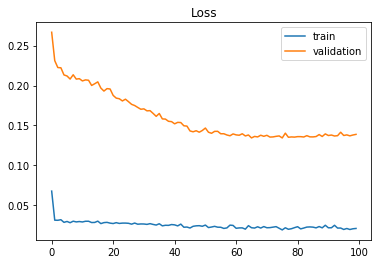

In [17]:

# plot loss during training
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()


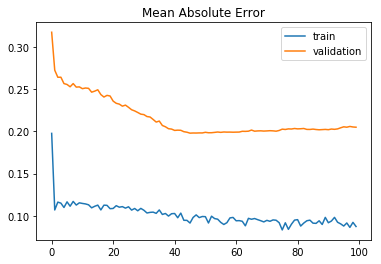

In [18]:

# plot mse during training
pyplot.title('Mean Absolute Error')
pyplot.plot(history.history['mae'], label='train')
pyplot.plot(history.history['val_mae'], label='validation')
pyplot.legend()
pyplot.show()

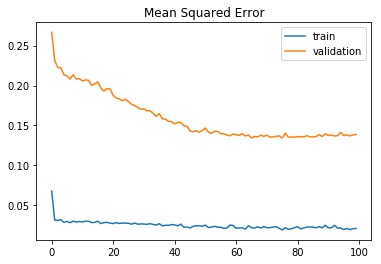

In [19]:
# plot mse during training
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['mse'], label='train')
pyplot.plot(history.history['val_mse'], label='validation')
pyplot.legend()
pyplot.show()

In [20]:
# def lstm_prediction(X_test_scaled, y_test_scaled,model_fitted,scaler):
#     '''
#     This function predicts y values and recover the original prices, and then creates a dataframe of Acural and Predicted values of y
#     '''
#     y_predicted = model_fitted.predict(X_test_scaled.reshape(X_test_scaled.shape[0],X_test_scaled.shape[1],-1))

#     # Recover the original prices instead of the scaled version
#     predicted = scaler.inverse_transform(y_predicted)
#     actual = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

#     prediction_df = pd.DataFrame({
#         "actual":actual.ravel(),
#         "predicted":predicted.ravel(),
#     })

#     return prediction_df


In [21]:
prediction_df = lstm_prediction(X_test_scaled, y_test_scaled, model_fitted,scaler)
prediction_df

2/2 [==============================] - 0s 1ms/step


,actual,predicted
0,5.9200,13.078313
1,18.2150,11.898729
2,24.8100,10.331122
3,18.9000,13.228402
4,15.0800,13.824229
...,...,...
58,18.3100,12.299438
59,18.9400,15.539367
60,13.9000,16.074272
61,17.1818,17.830704


In [22]:
# def predicted_plotting(df, ylabel,title):
#     '''
#     This function plots the actual prices vs. the predicted values.
#     '''
#     return df[["actual","predicted"]].plot(
#                     ylabel= ylabel,
#                     title=title
# )

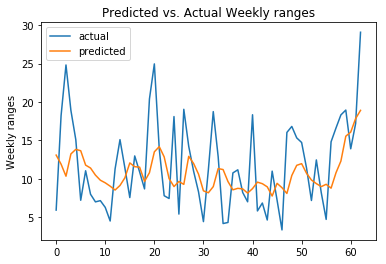

In [23]:
predicted_plotting(prediction_df,'Weekly ranges',"Predicted vs. Actual Weekly ranges")

# Ploting Funtions
---

In [27]:
def history_plotting(df, title):

    '''
    This function plots the historical data.
    '''

    return df.hvplot(
                    ylabel = 'Price in $',
                    width= 1000,
                    height=400,
                    title=title)
     

In [159]:
def moving_avgs_plotting(df,ma_column_1, ma_column_2, title):
    '''
    This function plots the overlay of the original prices and moving averages.
    '''
    prices = df['close'].hvplot(line_color='lightgray',
                        ylabel='Price in $',
                        width=1000,
                        height=400,
                        title=title
                        )

    moving_avgs = df[[ma_column_1, ma_column_2]].hvplot(
                            ylabel='Price in $',
                            width=1000,
                            height=400
    )   

    return prices*moving_avgs

    

<AxesSubplot:title={'center':'predicted vs. actural'}, ylabel='range'>

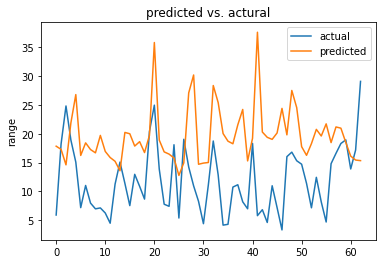

In [254]:
predicted_plotting(prediction_df,'range', 'predicted vs. actural')

In [255]:
prediction_df

,actual,predicted
0,5.9200,17.841833
1,18.2150,17.295267
2,24.8100,14.612334
3,18.9000,21.886631
4,15.0800,26.779917
...,...,...
58,18.3100,20.965147
59,18.9400,18.488190
60,13.9000,16.120464
61,17.1818,15.441918


In [161]:
def predicted_plotting(df, ylabel,title):
    '''
    This function plots the actual prices vs. the predicted values.
    '''
    return df[["actual","predicted"]].plot(
                    ylabel= ylabel,
                    title=title
)

# .axvline(index, color='red',label='prediction start')

In [162]:
# def bands_plotting(df, title ):
#     '''
#     This function plots the range of the prices.
#     '''
#     close = df['close'].hvplot(
#         line_color="lightgray",
#         ylabel="Price in $",
#         width=1000,
#         height=400,
#         title=title
#     )

#     upper_band = df['upper'].hvplot(
#         line_color="purple",
#         ylabel = "Price in $",
#         width=1000,
#         height=400,
#     )

#     middle = df['middle'].hvplot(
#         line_color="orange",
#         ylabel = "Price in $",
#         width = 1000,
#         height = 400
#     )


#     lower_band = df['lower'].hvplot(
#         line_color="blue",
#         ylabel = "Price in $",
#         width = 1000,
#         height = 400
#     )

#     # Overlay plots
#     return close * upper_band *middle *lower_band

In [163]:
# def entry_exit_positions(df, title):
#     '''
#     This function plots the entry/exit positions using ranges.
#     '''
#     entry = df[df["signal"] == 1.0]["close"].hvplot.scatter(
#     color="green",
#     marker="^",
#     size=200,
#     legend=False,
#     ylabel="Price in $",
#     title=title,
#     width=1000,
#     height=400,
# )

# # Visualize exit position relative to close price
#     exit = df[df["signal"] == -1.0]["close"].hvplot.scatter(
#     color="red",
#     marker="v",
#     size=200,
#     legend=False,
#     ylabel="Price in $",
#     width=1000,
#     height=400
# )

# # Visualize close price for the investment
#     close = df[["close"]].hvplot(
#     line_color="lightgray",
#     ylabel="Price in $",
#     width=1000,
#     height=400
# )

#     upper = df[["upper"]].hvplot(
#     line_color="purple",
#     ylabel="Price in $",
#     width=1000,
#     height=400
# )

#     middle = df[["middle"]].hvplot(
#     line_color="orange",
#     ylabel="Price in $",
#     width=1000,
#     height=400
# )

#     lower = df[["Lower"]].hvplot(
#     line_color="blue",
#     ylabel="Price in $",
#     width=1000,
#     height=400
# )


# # Overlay plots
#     return close * upper * middle * lower * entry * exit